In [ ]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(Seurat)
library(Signac)
library(harmony)
library(data.table)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/Paired-HiC/phc_help.R")

## Plot ecDNA structure and RPKM heatmap together (Fig.6F)

In [47]:
dmtp_cnv <- list()
dmtp_cell <- 0

bc <- read.table("GBM39_GBM39ERL_top200cells_by_clusters.xls")
for (f in bc$V1){
    tryCatch({
        lib <- substr(f, 1, 5)
        tmp <- fread(paste0("../04.matrices/230915/", lib, "_single_cell/", f, "/10000.CNV.bedGraph"))
        colnames(tmp) <- c("chrom", "start", "end", "residuals")
        ### subset only this region: chr8_126500000_128500000
        tmp <- tmp[tmp$chrom == "chr8" & tmp$start >= 126500000 & tmp$end <= 130500000]
        tmp$sample <- f
        dmtp_cnv[[f]] <- tmp
        dmtp_cell = dmtp_cell + 1
    }, error = function(e) {
    # If an error occurs (e.g., file not found), print a message and continue to the next iteration
    cat(paste("Error: Unable to open file", f, ", Skipping to the next file.\n"))
  })
}

dmtp_cnv <- do.call(rbind, dmtp_cnv)
unique(dmtp_cnv$sample) %>% length

Error: Unable to open file LC731:GTTAGCTGTTATTTGG , Skipping to the next file.
Error: Unable to open file LC731:CCCTAATCATTCATTG , Skipping to the next file.
Error: Unable to open file LC731:TTTCTTGTCTAGTTCG , Skipping to the next file.
Error: Unable to open file LC731:GAGCACGGTAACCGCC , Skipping to the next file.
Error: Unable to open file LC731:TCTTGGATCAAGCCAG , Skipping to the next file.
Error: Unable to open file LC731:TAAGAAGCAGTTCCTG , Skipping to the next file.
Error: Unable to open file LC731:GCCAGTTTCCACTATG , Skipping to the next file.
Error: Unable to open file LC731:TCACTCGCATTTGTGC , Skipping to the next file.
Error: Unable to open file LC731:GGAGTCGGTTGAAGCA , Skipping to the next file.
Error: Unable to open file LC731:TCCTTTATCAATACAG , Skipping to the next file.
Error: Unable to open file LC731:TCCTTGAAGAGCAATC , Skipping to the next file.
Error: Unable to open file LC731:GGTGGATGTTGCAATC , Skipping to the next file.
Error: Unable to open file LC731:GGTGTGCAGTTACTAC , 

[1] 872

In [48]:
dmtp_cnv$bin <- paste0(dmtp_cnv$chrom, "_", dmtp_cnv$start)
bd <- dmtp_cnv[,c("bin", "residuals", "sample")] %>%
reshape2::dcast(sample ~ bin, value.var = "residuals") %>%
tibble::column_to_rownames("sample")

row_anno <- data.frame(sample = rownames(bd), cluster = mmg@meta.data[match(rownames(bd), paste0(mmg$dna_sample, ":", mmg$dna_bc)), "seurat_clusters"]) %>%
tibble::column_to_rownames('sample') %>%
arrange(match(cluster, c(3, 1, 4, 0, 2)))

row_numbers <- list()
for (value in unique(row_anno$cluster)) {
  row_numbers[[value]] <- which(row_anno$cluster == value)[1]
}

bd[bd > 16] <- 16

In [ ]:
mmg <- readRDS("GBM39_GBM39ERL_Paired-HiC_RNA_seurat.rds")

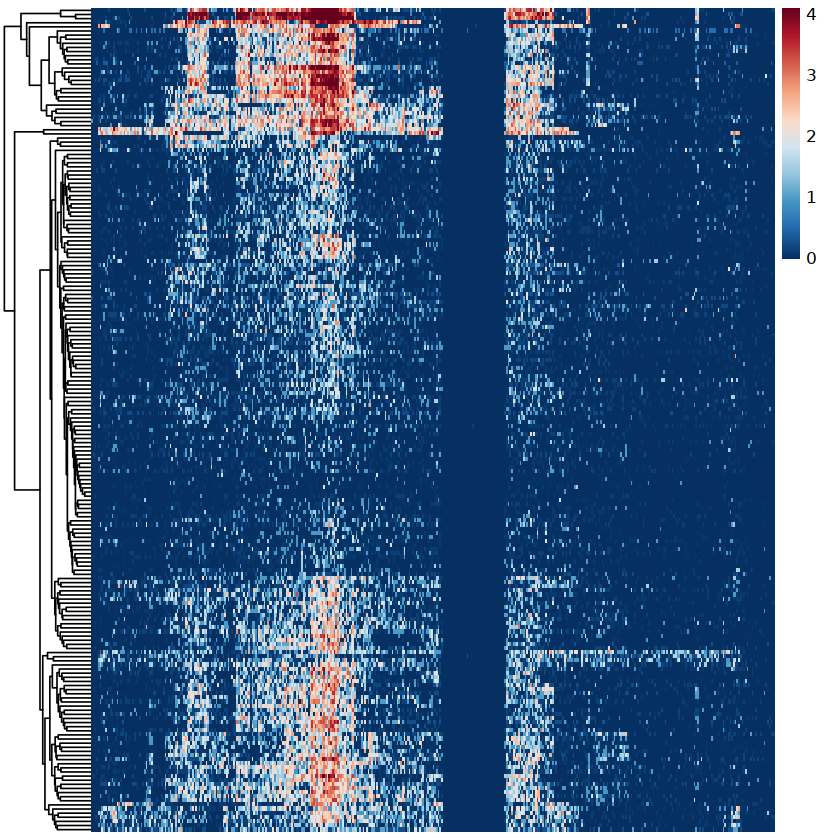

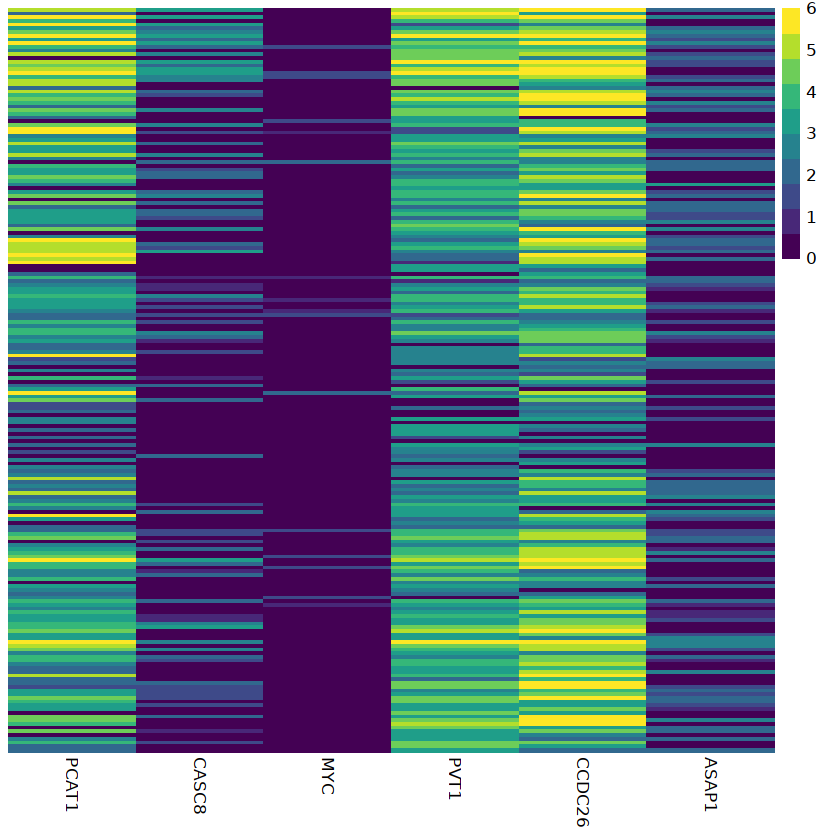

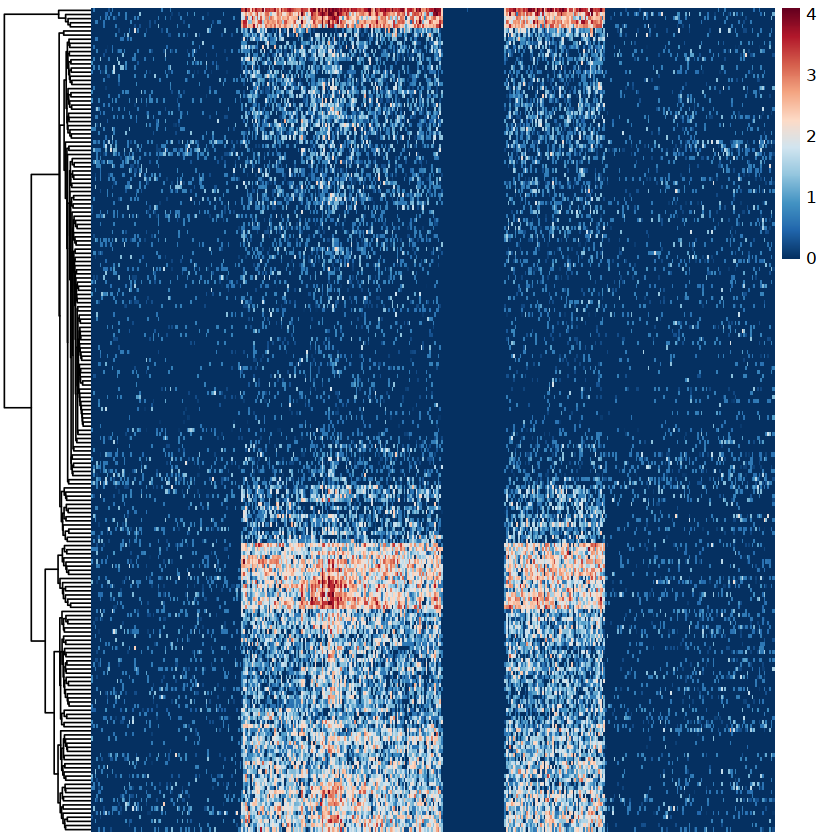

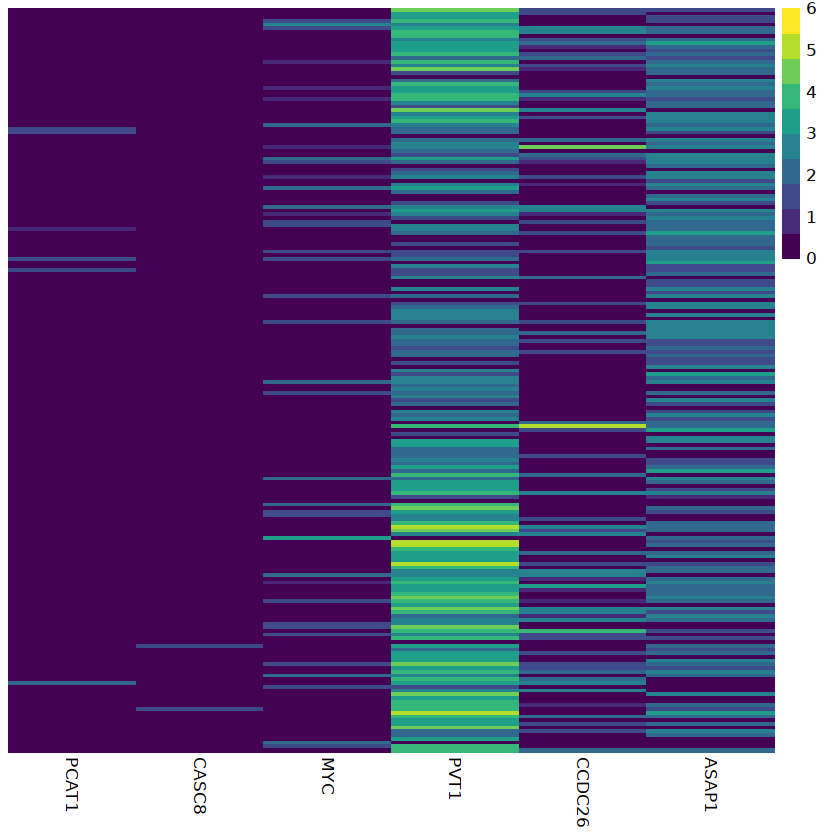

In [50]:
### run clustering on each cluster individually
suppressPackageStartupMessages(library(viridis))

row_anno2 <- row_anno %>% mutate(cluster = gsub("^([^:]+):([^:]+)$", "\\1", rownames(.))) %>% 
tibble::rownames_to_column("id") %>%
group_by(cluster) %>% slice_sample(n = 200) %>% ungroup() %>% 
tibble::column_to_rownames("id")


display_gene <- c("PCAT1", "CASC8", "MYC", "PVT1", "CCDC26", "ASAP1")
for (f in unique(row_anno2$cluster)){
    rnt <- row_anno2[row_anno2$cluster == f,,drop = F]
    tmp <- bd[rownames(row_anno2[row_anno2$cluster == f, , drop = F]), ]
    
    t1 <- log2(tmp + 1) %>% 
    pheatmap(border_color = NA, cluster_rows = T, cluster_cols = F, show_colnames = F, 
             # annotation_row = row_anno,
             show_rownames = F, color = colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(255))
    
    rtp <- mmg@meta.data[match(t1$tree_row$labels[t1$tree_row$order], paste0(mmg$dna_sample, ":", mmg$dna_bc)), ]
    tmp <- as.data.frame(mmg[["RNA"]]@data[display_gene, rownames(rtp)])
    tmp[tmp > 64] <- 64 
    t2 <- tmp %>%
    t %>%
    pheatmap(border_color = NA, cluster_rows = F, cluster_cols = F, show_rownames = F, breaks = seq(0, 6, 0.6),
             color = viridis(n = 10))
    ggsave(t1, filename = paste0("GBM39_GBM39ERL_cnv_by_cluster_", f, "_chr8_126-5_130-5.pdf"), dpi = 300, height = 3, width = 12)
    ggsave(t2, filename = paste0("GBM39_GBM39ERL_ecMYC_allgene_cluster_", f, "_RPKM_exp_chr8_126-5_130-5.pdf"), dpi = 300, height = 3, width = 6)
}

## ecDNA and gene expression correlation (Fig.6G)

In [35]:
suppressPackageStartupMessages(library(GenomicRanges))
hg38 <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
# cdg <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-arc-GRCh38-2020-A-2.0.0/coding_gene.bed")
hg38_genes.gr = GRanges(hg38[, 1], IRanges::IRanges(hg38[, 2], hg38[, 3]), gene = hg38[,6])
 
qry1 <- data.frame(chr = "chr8", start = 127360000, end = 129490000) ### range in GBM39
qry2 <- data.frame(chr = "chr8", start = 126520000, end = 130290000) ### range in GBM39ERL

qry1.gr = GRanges(qry1[, 1], IRanges::IRanges(qry1[, 2], qry1[, 3]))
qry2.gr = GRanges(qry2[, 1], IRanges::IRanges(qry2[, 2], qry2[, 3]))

qry1.gene <- hg38[unique(queryHits(findOverlaps(hg38_genes.gr, qry1.gr))), ]
qry2.gene <- hg38[unique(queryHits(findOverlaps(hg38_genes.gr, qry2.gr))), ]

diffgene <- setdiff(qry2.gene$V6, qry1.gene$V6)
diffgene <- intersect(rownames(mmg[["RNA"]]@counts), diffgene)
diffgene
length(diffgene)

[1] "AC084116.3" "LRATD2"     "AC024382.1" "CASC19"     "PRNCR1"    
 [6] "AC018714.2" "AC103718.1" "GSDMC"      "AC022973.5" "FAM49B"    
[11] "AC022973.4" "AC022973.3" "AC131568.1" "ASAP1"      "ASAP1-IT2" 
[16] "AC009682.1"

[1] 16

In [36]:
### calculate RPKM
mmg_rpkm <- ArcXPM2(obj_mtx = mmg[["RNA"]]@counts, meta = mmg@meta.data, method = "RPKM", group.by = "dna_sample", 
      gene_length = "/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
head(mmg_rpkm)

sparsity: 0.238244856697904
check readSums:  2 
check obj_mtx_collapse:  2 


,LC648,LC731
MIR1302-2HG,0.063692391,0.000000000
FAM138A,0.000000000,0.000000000
OR4F5,0.000000000,0.000000000
AL627309.1,0.006687787,0.008646207
AL627309.3,0.000000000,0.000000000
AL627309.2,0.000000000,0.000000000


In [42]:
qry_left <- data.frame(chr = "chr8", start = 126520000, end = 127360000) ### range in GBM39
qry_right <- data.frame(chr = "chr8", start = 129490000, end = 130290000) ### range in GBM39ERL

qry_left.gr = GRanges(qry_left[, 1], IRanges::IRanges(qry_left[, 2], qry_left[, 3]))
qry_right.gr = GRanges(qry_right[, 1], IRanges::IRanges(qry_right[, 2], qry_right[, 3]))

qry_left.gene <- hg38[unique(queryHits(findOverlaps(hg38_genes.gr, qry_left.gr))), ]
qry_right.gene <- hg38[unique(queryHits(findOverlaps(hg38_genes.gr, qry_right.gr))), ]

left_gene <- intersect(rownames(mmg_rpkm), qry_left.gene$V6)
right_gene <- intersect(rownames(mmg_rpkm), qry_right.gene$V6)

left_gene
right_gene
middle_gene <- setdiff(qry1.gene$V6, union(left_gene, right_gene))
gene_type <- data.frame(gene = c(left_gene, middle_gene, right_gene), 
                        class = c(rep("left", length(left_gene)), rep("middle", length(middle_gene)), rep("right", length(right_gene))))
head(gene_type)

[1] "AC084116.3" "LRATD2"     "PCAT1"      "AC024382.1" "CASC19"    
[6] "PRNCR1"     "AC018714.2" "CASC8"      "POU5F1B"

[1] "CCDC26"     "AC103718.1" "GSDMC"      "AC022973.5" "FAM49B"    
 [6] "AC022973.4" "AC022973.3" "AC131568.1" "ASAP1"      "ASAP1-IT2" 
[11] "AC009682.1"

,gene,class
,<chr>,<chr>
1,AC084116.3,left
2,LRATD2,left
3,PCAT1,left
4,AC024382.1,left
5,CASC19,left
6,PRNCR1,left


In [55]:
### gene body bin copy number

### make 10kb gr
start_df <- colnames(bd[rownames(row_anno), ])[1] %>% stringr::str_split_fixed(pattern = "_", n = 2) %>% as.data.frame
end_df <- colnames(bd[rownames(row_anno), ])[ncol(bd)] %>% stringr::str_split_fixed(pattern = "_", n = 2) %>% as.data.frame
range_df <- seq(as.numeric(start_df$V2), as.numeric(end_df$V2), 10000) %>% as.integer
range_df <- data.frame(chrom = rep("chr8", length(range_df)-1), start = range_df[-length(range_df)], end = range_df[-1])
range_gr <- GRanges(range_df$chrom, IRanges::IRanges(range_df$start, range_df$end))

### intersect with genes
t1 <- range_gr[subjectHits(findOverlaps(hg38_genes.gr[hg38_genes.gr$gene %in% uniongene,], range_gr)), ] %>% as.data.frame
t2 <- hg38_genes.gr[hg38_genes.gr$gene %in% uniongene,][queryHits(findOverlaps(hg38_genes.gr[hg38_genes.gr$gene %in% uniongene,], range_gr)), ] %>% as.data.frame
intersect_df <- cbind(t1[,1:3], t2[,c(1:3,6)]) %>%
setNames(c("chrom", "start", "end", "gchrom", "gstart", "gend", "gene")) %>%
mutate(bin = paste0(chrom, "_", start))

### now turn bd into gene by cell cnv matrix
gene_cnv <- matrix(nrow = nrow(bd[rownames(row_anno), ]), ncol = length(unique(intersect_df$gene)), data = 0)
colnames(gene_cnv) <- unique(intersect_df$gene)
rownames(gene_cnv) <- rownames(row_anno)
gene_cnv <- gene_cnv %>% as.data.frame

for (f in unique(intersect_df$gene)){
    biname <- intersect_df[intersect_df$gene %in% f, "bin"]
    gene_cnv[,f] <- apply(bd[rownames(row_anno), biname, drop = F], MARGIN = 1, mean)
}

### prepare cell by gene matrix
rtp <- mmg@meta.data[match(rownames(gene_cnv), paste0(mmg$dna_sample, ":", mmg$dna_bc)), ]
gene_rna <- as.data.frame(mmg[["RNA"]]@data[uniongene, rownames(rtp)]) %>% t
tmp <- mmg@meta.data[match(rownames(gene_rna), rownames(mmg@meta.data)), ]
rownames(gene_rna) <- paste0(tmp$dna_sample, ":", tmp$dna_bc)

cls_meta <- data.frame(bc = rownames(gene_rna), 
                       cls = mmg@meta.data[match(rownames(gene_rna), paste0(mmg$dna_sample, ":", mmg$dna_bc)), "dna_sample"])

### now calculate correlation between gene count and cnv
### by sample!!

cor_df_cls <- list()
for (f in colnames(gene_rna)){### all genes
    for (cls in unique(cls_meta$cls)){
        bcc <- cls_meta[cls_meta$cls == cls, "bc"]
        cor_df_cls[[paste0(f, "_", cls)]] <- cor(gene_cnv[bcc,f], gene_rna[bcc,f], method = "spearman")
    }
}


tmp <- cor_df_cls %>%
as.data.frame %>%
t %>% as.data.frame %>% setNames("SCC") %>%
tibble::rownames_to_column("tmp")
tmp[,c("gene", "cls")] <- stringr::str_split_fixed(tmp$tmp, pattern = "_", n = 2)

tmp <- tmp %>% mutate(cls = factor(cls, levels = c("LC731", "LC648")))
tmp <- merge(tmp, gene_type, by = "gene")

Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene_cnv[bcc, f], gene_rna[bcc, f], method = "spearman"):
“the st

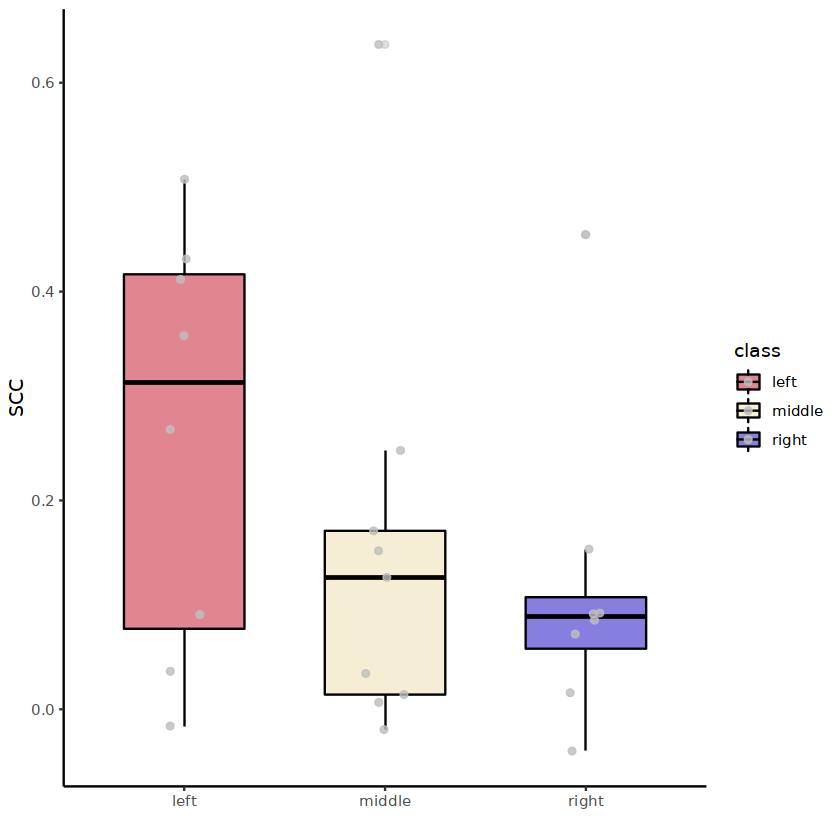

In [66]:
t1 <- tmp %>% 
filter(!is.na(SCC) & cls == "LC648") %>%
ggplot(aes(x = class, y = SCC, fill = class)) + 
geom_boxplot(width = 0.6, color = "black", alpha = 0.5, coef = 2, 
             outlier.color = "grey", position=position_dodge(width = 0.8)) + 
geom_jitter(color = "grey", alpha = 0.8, width = 0.1) + 
theme_classic() + xlab("") + 
scale_fill_manual(values = c('#c30d23', '#eeddaa', '#1100bf'))

t1

ggsave(t1, filename = "GBM39ERL_uniongene_on_ecMYC_exp_cnv_scc_by_samples_location.pdf", dpi = 300, height = 6, width = 7)
write.table(t1$data, "GBM39ERL_uniongene_on_ecMYC_exp_cnv_scc_by_samples_location.txt", quote = F, sep = "\t")

## Classify GBM39 states (Fig.6H-I)

In [4]:
mmg <- readRDS("GBM39_GBM39ERL_Paired-HiC_RNA_seurat.rds")

In [5]:
### Function for getScore and getQuadrant
source("/projects/ps-renlab2/y2xie/scripts/scrabble_score.R")
source("/projects/ps-renlab2/y2xie/scripts/scrabble_hierarchy.R")
source("/projects/ps-renlab2/y2xie/scripts/scrabble_bin.R")

In [7]:
### Load gene module
module <- read.csv("../../public_data/GBM_GeneModule.csv")
gene_sets <- as.list(as.data.frame(module))

### Merge names
gene_sets[["MES"]] <- union(gene_sets[["MES1"]], gene_sets[["MES2"]]) %>% unique
gene_sets[["NPC"]] <- union(gene_sets[["NPC1"]], gene_sets[["NPC2"]]) %>% unique
gene_sets <- gene_sets[c("MES", "OPC", "NPC", "AC")]

for (cls in names(gene_sets)){
    gene_sets[[cls]] <- intersect(gene_sets[[cls]], rownames(mmg[["RNA"]]@counts))
}

tmp <- mmg
sc <- score(tmp[["RNA"]]@counts, groups = gene_sets, binmat = NULL, bins = NULL, 
                      controls = NULL, bin.control = F, center = T, nbin = 30, n = 100, replace = T) %>% 
as.data.frame(.)

h <- hierarchy(sc[,c("OPC", "NPC", "AC", "MES")], 
               quadrants = c("OPC", "NPC", "AC", "MES"), log.scale = T)

# c("bl", "br", "tl", "tr")
# Briefly, cells were first separated into
# OPC/-NPC-like vs. AC-/MES-like by the sign D = max(SCopc,SCnpc) - max(SCac,SCmes),
# and D defined the y-axis of all cells. Next, for OPC-/NPC-like cells, the x-axis value was
# defined as log2(|SCnpc – SCopc|+1) and for AC-like/MES-like cells (i.e., D < 0), the x-axis
# was defined as log2(|SCmes – SCac|+1). 

In [9]:
tmp <- merge(sc, h, by = 0) %>%
tibble::column_to_rownames("Row.names")

write.table(tmp, "GBM39_phc_maglinant_butterfly_score.txt", sep = "\t", quote = F, row.names = T, col.names = T)

In [6]:
h <- read.table("GBM39_phc_maglinant_butterfly_score.txt")
h$class <- NA
h[h$X > 0 & h$Y > 0, ]$class <- "MES-like"
h[h$X > 0 & h$Y < 0, ]$class <- "NPC-like"
h[h$X < 0 & h$Y > 0, ]$class <- "AC-like"
h[h$X < 0 & h$Y < 0, ]$class <- "OPC-like"
h$library <- substr(rownames(h), 1, 5)

Warning message:
“Removed 11 rows containing missing values (geom_point).”


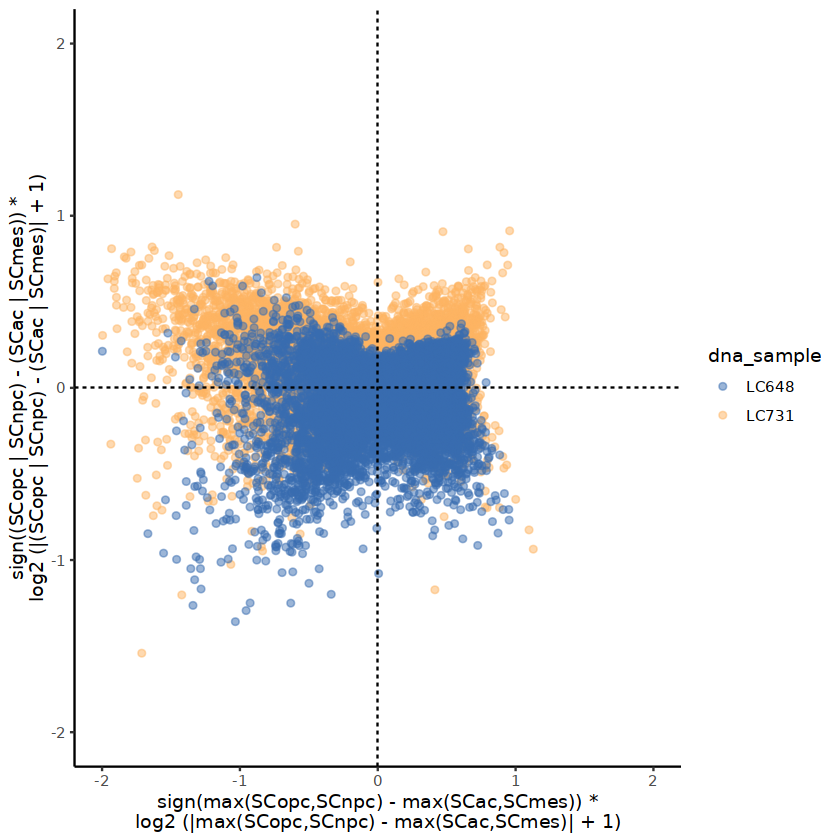

In [16]:
merge(h, mmg@meta.data, by = 0) %>%
ggplot(aes(x = X, y = Y, color = dna_sample)) + 
geom_point(alpha = 0.5) + xlim(-2, 2) + ylim(-2, 2) +
geom_hline(yintercept = 0, color = "black", linetype="dashed") + 
geom_vline(xintercept = 0, color = "black", linetype="dashed") + 
theme_classic() + 
scale_colour_Publication() + 
xlab("sign(max(SCopc,SCnpc) - max(SCac,SCmes)) *\nlog2 (|max(SCopc,SCnpc) - max(SCac,SCmes)| + 1)") + 
ylab("sign((SCopc | SCnpc) - (SCac | SCmes)) *\nlog2 (|(SCopc | SCnpc) - (SCac | SCmes)| + 1)")

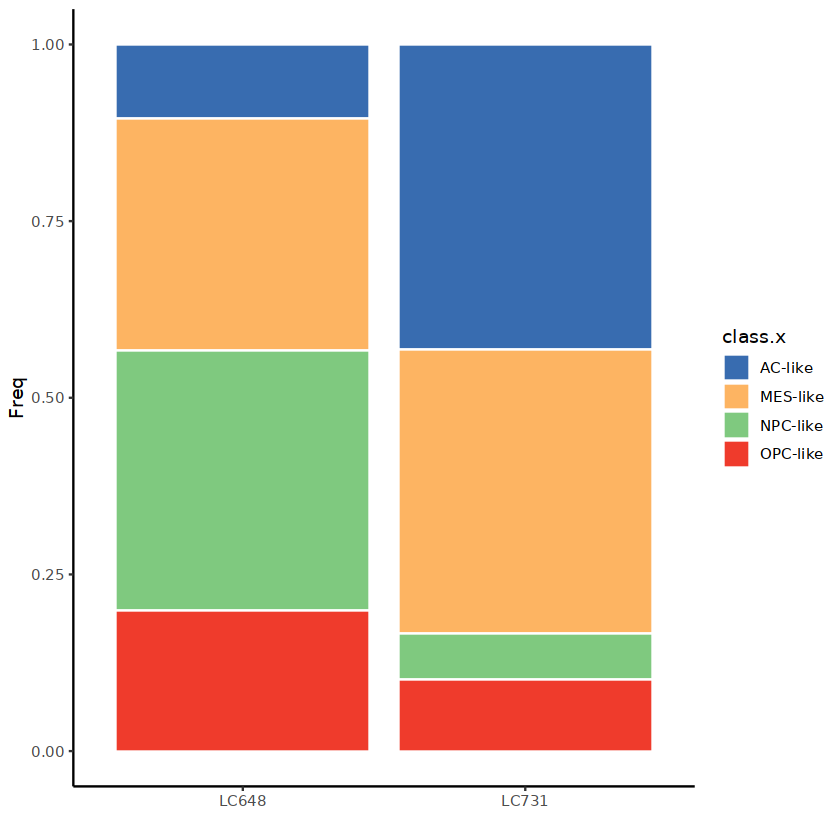

In [26]:
t1 <- merge(h, mmg@meta.data, by = 0) %>%
select(class.x, dna_sample) %>%
table %>% as.data.frame %>%
ggplot(aes(x = dna_sample, y = Freq, fill = class.x)) + 
geom_col(position = "fill", color = "white") + 
theme_classic() + scale_fill_Publication() + xlab("")

t1

ggsave(t1, filename = "GBM39_phc_states_by_sample.pdf", dpi = 300, height = 6, width = 6)
write.table(t1$data, "GBM39_phc_states_by_sample.txt", sep = "\t", quote = F)


 AC-like MES-like NPC-like OPC-like 
    4307     6791     4945     3123 

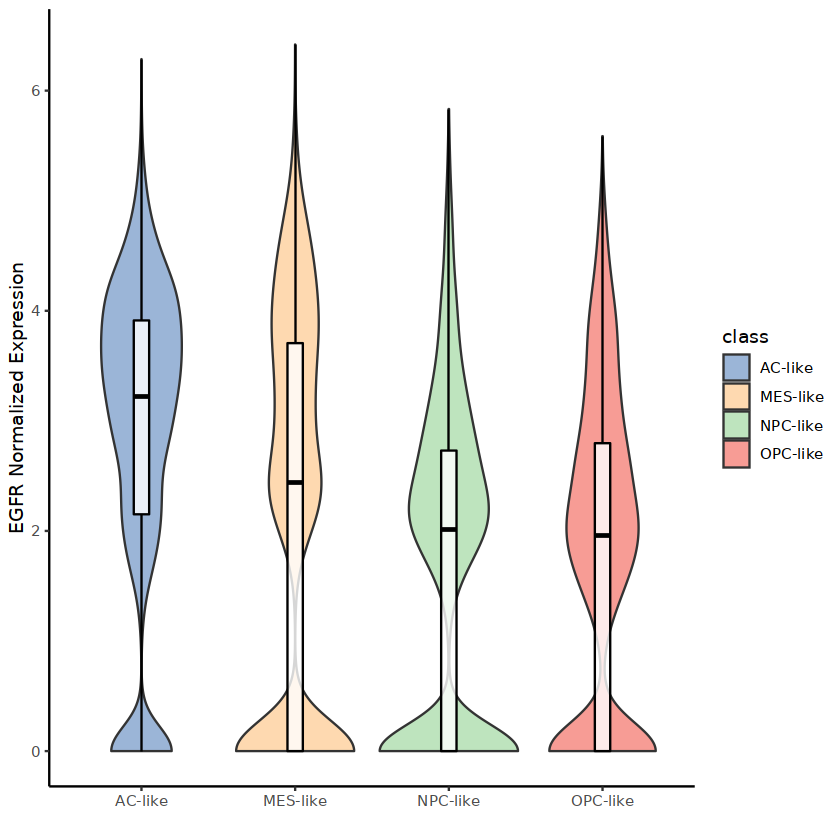

In [68]:
## check EGFR and MYC activity
mmg <- AddMetaData(mmg, h, colnames(h))
tt <- mmg[["RNA"]]@data["EGFR",] %>%
as.data.frame %>%
setNames("EGFR")

t1 <- cbind(mmg@meta.data, tt) %>%
# dplyr::filter(abs(X) > 0.2 & abs(Y) > 0.2) %>%
ggplot(aes(x = class, y = EGFR)) + 
geom_violin(aes(fill = class), alpha = 0.5) + 
geom_boxplot(width = 0.1, color = "black", 
             alpha = 0.8, coef = 2, outlier.alpha = 0.5) +
xlab("") + ylab("EGFR Normalized Expression") + 
scale_fill_Publication() + 
theme_classic()

t1
table(t1$data$class)

ggsave(t1, filename = "GBM39_RNA_cell_states_EGFR_normalized_exp_cutoff0.pdf", 
       dpi = 300, height = 6, width = 7)

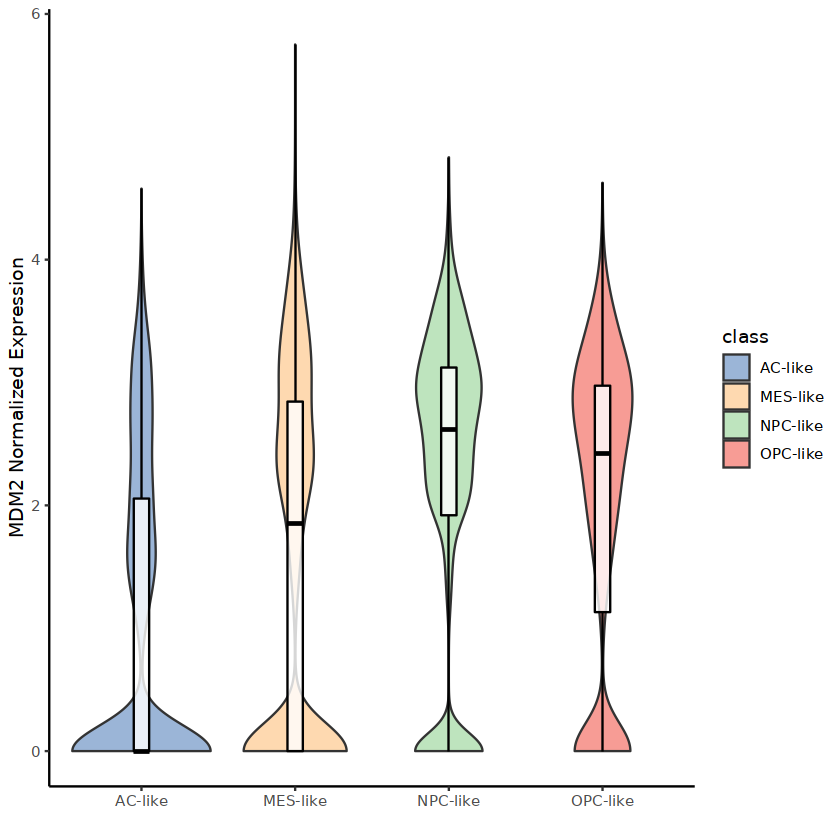

In [29]:
## check EGFR and MYC activity
# mmg <- AddMetaData(mmg, h, colnames(h))
tt <- mmg[["RNA"]]@data["MDM2",] %>%
as.data.frame %>%
setNames("MDM2")

t1 <- cbind(mmg@meta.data, tt) %>%
# dplyr::filter(abs(X) > 0.2 & abs(Y) > 0.2) %>%
ggplot(aes(x = class, y = MDM2)) + 
geom_violin(aes(fill = class), alpha = 0.5) + 
geom_boxplot(width = 0.1, color = "black", 
             alpha = 0.8, coef = 2, outlier.alpha = 0.5) +
xlab("") + ylab("MDM2 Normalized Expression") + 
scale_fill_Publication() + 
theme_classic()

t1

ggsave(t1, filename = "GBM39_RNA_cell_states_MDM2_normalized_exp_cutoff0.pdf", 
       dpi = 300, height = 6, width = 7)